<a href="https://colab.research.google.com/github/Bagito999/Deep-Learning/blob/main/CNN_TensorFlow_Klasifikasi_Ikan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models

# Setup path
base_path = "/content/drive/MyDrive/Deep Learning/FishImgDataset"
batch_size = 32
img_size = (64, 64)
AUTOTUNE = tf.data.AUTOTUNE

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_path, "train"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_path, "val"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_path, "test"),
    image_size=img_size,
    batch_size=1,
    label_mode="categorical",
    shuffle=False
)

Found 8819 files belonging to 31 classes.
Found 2751 files belonging to 31 classes.
Found 1761 files belonging to 31 classes.


In [3]:
# Class names
class_names = train_ds.class_names
num_classes = len(class_names)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
])

# Prefetching for performance
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [4]:
# CNN Model
model = models.Sequential([
    tf.keras.Input(shape=(*img_size, 3)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(num_classes, activation='softmax')
])

# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 1648s 6s/step - accuracy: 0.1591 - loss: 3.1991 - val_accuracy: 0.1407 - val_loss: 3.1910
Epoch 2/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 62s 222ms/step - accuracy: 0.2433 - loss: 2.7318 - val_accuracy: 0.2534 - val_loss: 2.6577
Epoch 3/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 60s 218ms/step - accuracy: 0.2834 - loss: 2.5665 - val_accuracy: 0.1240 - val_loss: 3.5020
Epoch 4/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 62s 224ms/step - accuracy: 0.3089 - loss: 2.4352 - val_accuracy: 0.2588 - val_loss: 2.6658
Epoch 5/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 82s 223ms/step - accuracy: 0.3339 - loss: 2.3816 - val_accuracy: 0.2268 - val_loss: 3.2820


1761/1761 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Akurasi     : 0.2118
Presisi     : 0.2644
Recall      : 0.2118
F1-Score    : 0.1885

Metrik terbaik berdasarkan nilai tertinggi adalah **Presisi** dengan nilai 0.2644


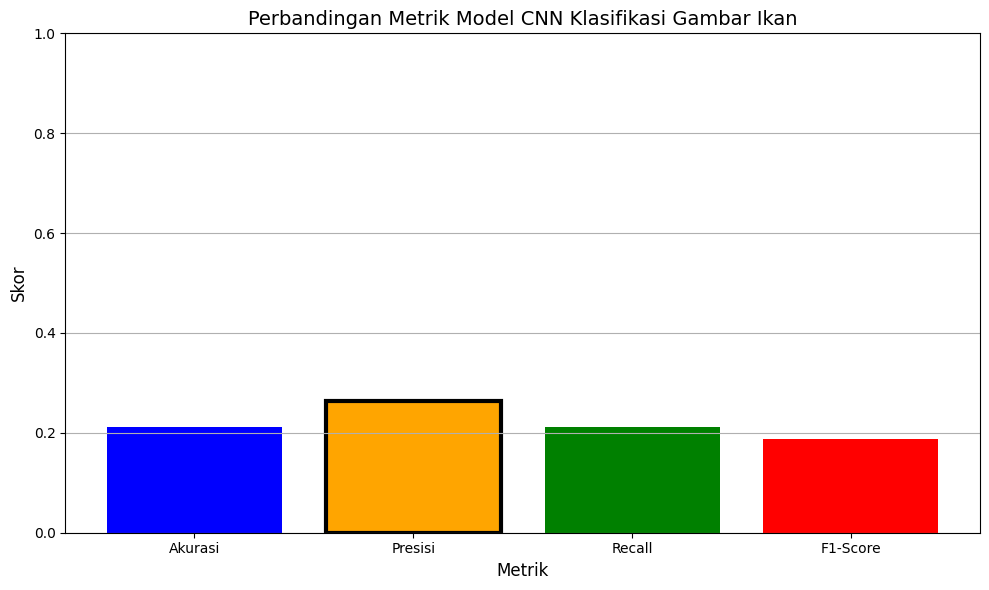

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# === Evaluation on Test Set ===

# Ambil label asli dari test_ds dan ubah ke bentuk kelas (jika one-hot)
y_true = np.array([y.numpy() for _, y in test_ds.unbatch()])
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)  # konversi dari one-hot ke label

# Prediksi probabilitas
y_pred_prob = model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluasi metrik
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Cetak hasil evaluasi
print(f"Akurasi     : {acc:.4f}")
print(f"Presisi     : {prec:.4f}")
print(f"Recall      : {rec:.4f}")
print(f"F1-Score    : {f1:.4f}")

# Dictionary metrik
metrics = {
    'Akurasi': acc,
    'Presisi': prec,
    'Recall': rec,
    'F1-Score': f1
}

# Metrik terbaik
best_metric = max(metrics, key=metrics.get)
print(f"\nMetrik terbaik berdasarkan nilai tertinggi adalah **{best_metric}** dengan nilai {metrics[best_metric]:.4f}")

# Visualisasi metrik
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green', 'red'])
plt.title('Perbandingan Metrik Model CNN Klasifikasi Gambar Ikan', fontsize=14)
plt.ylabel('Skor', fontsize=12)
plt.xlabel('Metrik', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y')

# Tandai metrik terbaik
for bar, label in zip(bars, metrics):
    if label == best_metric:
        bar.set_edgecolor('black')
        bar.set_linewidth(3)

plt.tight_layout()
plt.show()


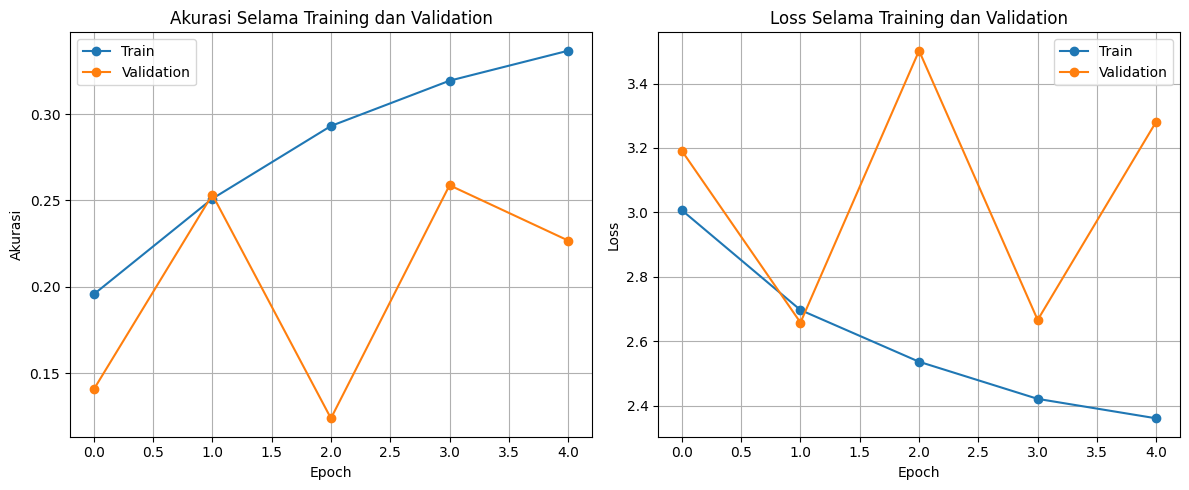

In [54]:
import matplotlib.pyplot as plt

# === Plot Accuracy & Loss ===
def plot_train_val(history):
    plt.figure(figsize=(12, 5))

    # Plot akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation', marker='o')
    plt.title('Akurasi Selama Training dan Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train', marker='o')
    plt.plot(history.history['val_loss'], label='Validation', marker='o')
    plt.title('Loss Selama Training dan Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Panggil fungsi visualisasi
plot_train_val(history)

Jumlah kelas di y_true: 28
Jumlah kelas di y_pred: 28
Jumlah kelas di test_generator: 3
Panjang y_true: 1589
Panjang y_pred: 1588
Jumlah data tidak konsisten antara y_true dan y_pred. Menyesuaikan dengan data yang valid.


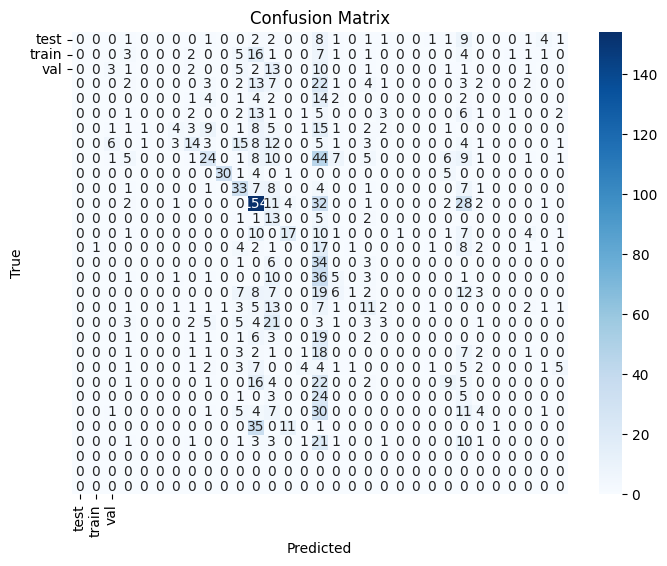

=== Classification Report ===
              precision    recall  f1-score   support

        test       0.00      0.00      0.00        34
       train       0.00      0.00      0.00        43
         val       0.25      0.07      0.12        40

    accuracy                           0.23      1588
   macro avg       0.22      0.16      0.13      1588
weighted avg       0.29      0.23      0.21      1588



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 31, does not match size of target_names, 3
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

In [62]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cek jumlah kelas yang ada di y_true, y_pred, dan test_generator
print(f"Jumlah kelas di y_true: {len(np.unique(y_true))}")
print(f"Jumlah kelas di y_pred: {len(np.unique(y_pred))}")
class_names = list(test_generator.class_indices.keys())
print(f"Jumlah kelas di test_generator: {len(class_names)}")

# Pastikan y_true dan y_pred memiliki jumlah yang sama
print(f"Panjang y_true: {len(y_true)}")
print(f"Panjang y_pred: {len(y_pred)}")

# Jika jumlahnya sama, lanjutkan ke confusion matrix
if len(y_true) == len(y_pred):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Visualisasikan confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names,
                yticklabels=class_names, cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title("Confusion Matrix")
    plt.show()

    # Pastikan jumlah kelas yang digunakan pada classification_report sesuai
    labels = list(range(len(class_names)))
    print("=== Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=class_names, labels=labels))
else:
    print("Jumlah data tidak konsisten antara y_true dan y_pred. Menyesuaikan dengan data yang valid.")
    # Menangani ketidaksesuaian jumlah data dengan memilih jumlah yang lebih kecil
    min_length = min(len(y_true), len(y_pred))
    y_true = y_true[:min_length]
    y_pred = y_pred[:min_length]

    # Confusion Matrix setelah penyesuaian
    cm = confusion_matrix(y_true, y_pred)

    # Visualisasikan confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names,
                yticklabels=class_names, cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title("Confusion Matrix")
    plt.show()

    # Classification report setelah penyesuaian
    print("=== Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=class_names, labels=labels))


1761/1761 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step
Jumlah data asli (y_true_bin): (1761, 31)
Jumlah data prediksi (y_pred_prob): (1761, 31)


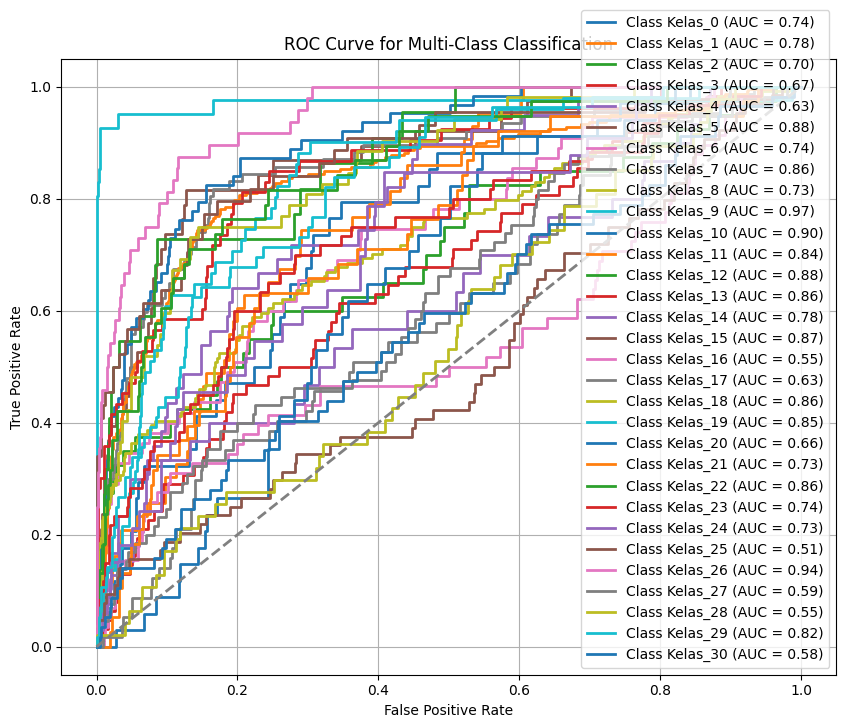

In [69]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize labels (karena ini adalah multi-class classification)
y_true = np.array([y.numpy() for _, y in test_ds.unbatch()])
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)  # konversi dari one-hot ke label

# Binarize labels for multi-class (one-vs-rest)
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

# Hitung probabilitas prediksi untuk setiap kelas dari test_ds
y_pred_prob = model.predict(test_ds)

# Pastikan jumlah sampel konsisten
print(f"Jumlah data asli (y_true_bin): {y_true_bin.shape}")
print(f"Jumlah data prediksi (y_pred_prob): {y_pred_prob.shape}")

# Hitung FPR, TPR, dan thresholds untuk setiap kelas
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve untuk setiap kelas
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Tambahkan label dan judul
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
